In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

In [4]:
from pathlib import Path
log_dir = Path('logs/')

In [5]:
from torch.utils.data import Dataset, DataLoader

class ModulatorDataset(Dataset):
    def __init__(self, bit_count):
        super().__init__()
        self.bit_count = bit_count
        
    def __len__(self):
        return 2 ** self.bit_count
    
    def __getitem__(self, idx):
        result = torch.zeros(2 ** self.bit_count)
        result[idx] = 1
        return result

bit_count = 4
class_count = 2 ** bit_count
dataset = ModulatorDataset(bit_count)
dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True)

In [6]:
class EntropyNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        energy = (x ** 2).sum(axis=1).mean()
        return x / energy.sqrt()

class AwgnNoise(pl.LightningModule):
    def __init__(self, snr):
        super().__init__()
        self.sigma = np.sqrt(1 / (2 * 10 ** (snr / 10)))
        
    def forward(self, x):
        return x + torch.normal(torch.zeros_like(x, device=self.device), 
                                torch.full_like(x, self.sigma, device=self.device))

class Clipper(pl.LightningModule):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
    def forward(self, data):
        min_bound = torch.tensor([-self.x, -self.y], device=self.device)
        max_bound = torch.tensor([self.x, self.y], device=self.device)
        return torch.clip(data, min_bound, max_bound)

class ClippingNoise(pl.LightningModule):
    def __init__(self, snr, x, y):
        super().__init__()
        self.awgn = AwgnNoise(snr)
        self.clipper = Clipper(x, y)
        
    def forward(self, x):
        x = self.awgn(x)
        return self.clipper(x)

    
class ModulatorAutoencoder(pl.LightningModule):
    def __init__(self, class_count, encoding_shape, noise):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(class_count, 4 * class_count),
            nn.ReLU(),
            nn.Linear(4 * class_count, encoding_shape),
            EntropyNormalization()
        )
        self.noise = noise
        self.decoder = nn.Sequential(
            nn.Linear(encoding_shape, 4 * class_count),
            nn.ReLU(),
            nn.Linear(4 * class_count, class_count),
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.symbol_error_rate = torchmetrics.Accuracy()
        
    def forward(self, x):
        encoded = self.encoder(x)
        noised = self.noise(encoded)
        return self.decoder(noised)
    
    def measure_error(self, dataloader, repeat=1000):
        correct = 0
        total = 0
        for _ in range(repeat):
            for batch in dataloader:
                decoded = self(batch)
                prediction = decoded.argmax(-1)
                true_classes = batch.argmax(-1)
                
                correct += (prediction == true_classes).detach().cpu().sum().item()
                total += batch.shape[0]
        return 1 - correct / total
    
    def training_step(self, batch, batch_idx):
        decoded = self(batch)
        prediction = decoded.argmax(-1)
        true_classes = batch.argmax(-1)
        loss = self.loss_function(decoded, batch)
        ser = self.symbol_error_rate(prediction, true_classes)
        self.log('ser', ser, on_epoch=True, on_step=False, prog_bar=True)
        self.log('loss', loss, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005)
        return optimizer

In [ ]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import ProgressBar
import tqdm


def train_models(bit_count, snrs, device_id=0, root_path=Path('model_storage')):
    class_count = 2 ** bit_count
    dataset = ModulatorDataset(bit_count)
    dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True, pin_memory=True)
    
    for snr in snrs:
        device = torch.device(f'cuda:{device_id}')
        x = 0.5
        y = 20.
        noise = ClippingNoise(snr, x, y).to(device)
        model = ModulatorAutoencoder(class_count, 2, noise).to(device)
        
        logger = CSVLogger(save_dir=log_dir)
        trainer = pl.Trainer(max_epochs=5000, logger=logger, gpus=[device_id])
        trainer.fit(model, train_dataloaders=dataloader)
        
        filename = f'clipping_{class_count}_{snr}_{x}_{y}.pt'
        path = root_path / filename
        torch.save(model.state_dict(), path)
        
# train_models(6, [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
# train_models(6, [40])
train_models(4, [14.5, 15., 15.5, 16., 16.5, 17])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 1.2 K 
1 | noise             | ClippingNoise    | 0     
2 | decoder           | Sequential       | 1.2 K 
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 4999: 100%|█████| 1/1 [00:00<00:00, 12.77it/s, loss=0.164, v_num=145, ser=0.938]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 1.2 K 
1 | noise             | ClippingNoise    | 0     
2 | decoder           | Sequential       | 1.2 K 
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 4999: 100%|█████| 1/1 [00:00<00:00, 13.76it/s, loss=0.113, v_num=146, ser=0.938]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 1.2 K 
1 | noise             | ClippingNoise    | 0     
2 | decoder           | Sequential       | 1.2 K 
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 4999: 100%|█████| 1/1 [00:00<00:00, 13.58it/s, loss=0.091, v_num=156, ser=1.000]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 1.2 K 
1 | noise             | ClippingNoise    | 0     
2 | decoder           | Sequential       | 1.2 K 
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 4999: 100%|████| 1/1 [00:00<00:00, 15.97it/s, loss=0.0657, v_num=160, ser=1.000]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 1.2 K 
1 | noise             | ClippingNoise    | 0     
2 | decoder           | Sequential       | 1.2 K 
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 4999: 100%|████| 1/1 [00:00<00:00, 15.39it/s, loss=0.0751, v_num=163, ser=1.000]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 1.2 K 
1 | noise             | ClippingNoise    | 0     
2 | decoder           | Sequential       | 1.2 K 
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 4791:   0%|            | 0/1 [00:00<?, ?it/s, loss=0.0377, v_num=164, ser=1.000]

In [ ]:
bit_count = 4
class_count = 2 ** bit_count
dataset = ModulatorDataset(bit_count)
dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True, pin_memory=True)

device_id = 0
device = torch.device(f'cuda:{device_id}')
snr = 16
noise = ClippingNoise(snr, 0.6, 2.).to(device)
model = ModulatorAutoencoder(class_count, 2, noise).to(device)

logger = CSVLogger(save_dir=log_dir)
trainer = pl.Trainer(max_epochs=30000, logger=logger, gpus=[device_id])
trainer.fit(model, train_dataloaders=dataloader)

root_path=Path('model_storage')
filename = f'clipping_{class_count}_{snr}.pt'
path = root_path / filename
torch.save(model.state_dict(), path)

In [52]:
ls

Baseline64.ipynb  ClippingNoise.ipynb  LSTM.ipynb      TestDropout.ipynb
Baseline.ipynb    logs/                model_storage/


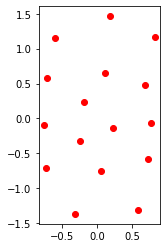

In [8]:
bit_count = 4
class_count = 2 ** bit_count
dataset = ModulatorDataset(bit_count)
dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True)

# class_count = 64
device_id=0
device = torch.device(f'cuda:{device_id}')
snr = 16
noise =  ClippingNoise(snr, 0.6, 2.).to(device)
loaded = ModulatorAutoencoder(class_count, 2, noise)
loaded.load_state_dict(torch.load(Path('model_storage/clipping_16_15.5_0.6_2.0.pt')))
# loaded = model
# loaded.eval()

outputs = []
for batch in dataloader:
    cur_outputs = loaded.to(device).encoder(batch.to(device))
    outputs.append(cur_outputs.cpu().detach().numpy())
points = np.concatenate(outputs)
plt.gca().set_aspect('equal', adjustable='box')
for point in points:
    plt.scatter(x=point[0], y=point[1], c='red')

In [62]:
ls

Baseline64.ipynb  ClippingNoise.ipynb  LSTM.ipynb      TestDropout.ipynb
Baseline.ipynb    logs/                model_storage/


In [13]:
torch.cuda.empty_cache()

In [20]:
predictions = []
labels = []

model.eval()
for _ in range(100000):
    for batch in dataloader:
        encoded = model.to(device).encoder(batch.to(device))
        noise = torch.normal(torch.zeros(encoded.shape, device=device), 
                             torch.ones(encoded.shape, device=device) / 10)
        noised = encoded + noise
        decoded = model.to(device).decoder(noised)
        cur_prediction = decoded.cpu().detach().argmax(-1).numpy()
        cur_labels = batch.argmax(-1).numpy()
        labels.append(cur_labels)
        predictions.append(cur_prediction)

true_labels = np.concatenate(labels)
model_predictions = np.concatenate(predictions)

error_count = (true_labels != model_predictions).sum()
ser = error_count / len(true_labels)
ser

0.003626875

In [14]:
2

2

In [ ]:
## 1 - (1 - 2Q(sqrt(3E/N_0 * 1 / (q - 1)))) ^ 2
## Q(x) = erfc(x / sqrt(2)) / 2
## erfc(x) = 1 - erf(x)
## erf(x) = 2 / sqrt(pi) * int_0^x e^(-z^2)dz

/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


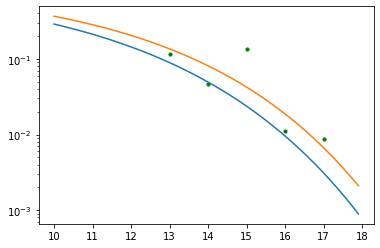

In [18]:
from scipy.special import erfc

def Q(x):
    return erfc(x / np.sqrt(2)) / 2

def p_error(snr, q=16):
    sigma = 1 / 2 / (10 ** (snr / 10))
    n0 = 2 * sigma
    return 1 - (1 - 2 * Q(np.sqrt(3 / n0 / (q - 1)))) ** 2

def p_stupid(snr, q=16):
    sigma = 1 / 2 / (10 ** (snr / 10))
    n0 = 2 * sigma
    return np.exp(-3 / 2 / (q - 1) / n0)

snrs = np.arange(10, 18, 0.1)
plt.yscale('log')
# for q in [4, 16, 64]:
for q in [16]:
    ys = [p_error(snr, q) for snr in snrs]
    zs = [p_stupid(snr, q) for snr in snrs]
    plt.plot(snrs, ys)
    plt.plot(snrs, zs)


bit_count = 4
class_count = 2 ** bit_count
nn_probs = []
nn_snrs = [13, 14, 15, 16, 17]
for snr in nn_snrs:
    loaded = ModulatorAutoencoder(class_count, 2, snr)
    loaded.load_state_dict(torch.load(Path(f'model_storage/ae_{class_count}_{snr}.pt')))
    loaded.eval()
    
    dataset = ModulatorDataset(bit_count)
    dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True, pin_memory=True)
    
    correct = 0
    total = 0
    for _ in range(10 ** 3):
        for batch in dataloader:
            prediction = loaded(batch).cpu().detach().argmax(-1)
            true_labels = batch.argmax(-1)
            correct += (true_labels == prediction).sum().item()
            total += class_count
    nn_probs.append(1 - correct / total)
    
plt.scatter(nn_snrs, nn_probs, s=10, c='green');